In [ ]:
import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats

In [ ]:
df = pd.concat(
    [pd.read_csv(path) for path in glob.glob("tennis_atp/atp_matches_[12][09][01298]*")],
    axis=0
)

In [ ]:
df.dropna(subset=['winner_rank', 'loser_rank', 'score'], inplace=True)
df.tourney_date.apply(lambda x: "%.0f" % round(x, 0))
df.loc[:, "tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")
df["score"] = df["score"].astype("string")
df["sets_num"] = df["score"].map(lambda x: len(x.split()))

df = df.reset_index(drop=True)
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,sets_num
0,2019-M020,Brisbane,Hard,32,A,2018-12-31,300,105453,2.0,NaN,...,34.0,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3
1,2019-M020,Brisbane,Hard,32,A,2018-12-31,299,106421,4.0,NaN,...,36.0,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,2
2,2019-M020,Brisbane,Hard,32,A,2018-12-31,298,105453,2.0,NaN,...,15.0,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,2
3,2019-M020,Brisbane,Hard,32,A,2018-12-31,297,104542,NaN,PR,...,38.0,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,2
4,2019-M020,Brisbane,Hard,32,A,2018-12-31,296,106421,4.0,NaN,...,46.0,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128496,2014-605,Tour Finals,Hard,8,F,2014-11-09,514,104925,1.0,NaN,...,29.0,5.0,11.0,3.0,9.0,1.0,10010.0,5.0,4625.0,3
128497,2014-605,Tour Finals,Hard,8,F,2014-11-09,515,104925,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,10010.0,2.0,8700.0,1
128498,2014-D015,Davis Cup WG F: FRA vs SUI,Clay,4,D,2014-11-21,1,104527,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,5295.0,12.0,2740.0,4
128499,2014-D015,Davis Cup WG F: FRA vs SUI,Clay,4,D,2014-11-21,2,104792,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.0,1825.0,2.0,9700.0,3


1. Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждения:

а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

Подготовим дата-сет. Добавим в него признаки is_rank_more_than_20 и is_rank_in_5:

In [ ]:
winners_with_rank = df.copy()
winners_with_rank["is_rank_more_than_20"] = df['winner_rank'] - df['loser_rank'] > 20
winners_with_rank["is_rank_in_5"] = abs(df['winner_rank'] - df['loser_rank']) <= 5

Создадим дата-сеты с выбоками по победам в зависимости от ранга:

In [ ]:

min_year = 1990
max_year = 2018

winners_more_than_20 = winners_with_rank.loc[
    (winners_with_rank["is_rank_more_than_20"] == True) &
    (winners_with_rank["tourney_date"].dt.year >= min_year) &
    (winners_with_rank["tourney_date"].dt.year <= max_year)
].copy()
winners_less_than_20 = winners_with_rank.loc[
    (winners_with_rank["is_rank_more_than_20"] == False) &
    (winners_with_rank["tourney_date"].dt.year >= min_year) &
    (winners_with_rank["tourney_date"].dt.year <= max_year)
].copy()

winners_in_5 = winners_with_rank.loc[
    (winners_with_rank["is_rank_in_5"] == True) &
    (winners_with_rank["tourney_date"].dt.year >= min_year) &
    (winners_with_rank["tourney_date"].dt.year <= max_year)
].copy()
winners_in_more_than_5 = winners_with_rank.loc[
    (winners_with_rank["is_rank_in_5"] == False) &
    (winners_with_rank["tourney_date"].dt.year >= min_year) &
    (winners_with_rank["tourney_date"].dt.year <= max_year)
].copy()

Затем разобъём наши выборки по годам:

In [ ]:

annual_winners_more_than_20 = winners_more_than_20.groupby(winners_more_than_20["tourney_date"].dt.year).count()["tourney_id"]
annual_winners_less_than_20 = winners_less_than_20.groupby(winners_less_than_20["tourney_date"].dt.year).count()["tourney_id"]
annual_winners_in_5 = winners_in_5.groupby(winners_in_5["tourney_date"].dt.year).count()['tourney_id']
annual_winners_in_more_than_5 = winners_in_more_than_5.groupby(winners_in_more_than_5["tourney_date"].dt.year).count()['tourney_id']

Посчитаем шанс победы, если победитель выше в ранге больше чем на 20 позиций:

In [ ]:
chance_to_win_more_than_20 = pd.concat(
    [ 
        annual_winners_more_than_20 / (annual_winners_more_than_20 + annual_winners_less_than_20)
    ], 
    axis=1
)

<AxesSubplot: xlabel='tourney_date'>

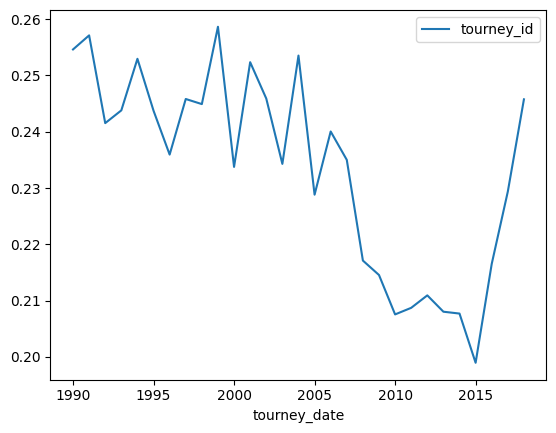

In [ ]:
sns.lineplot(data=chance_to_win_more_than_20)

Теперь вычислим шанс победы, если разница в ранге между оппонентами не больше 5:

In [ ]:
chance_to_win_in_5 = pd.concat(
    [ 
        annual_winners_in_5 / (annual_winners_in_5 + annual_winners_in_more_than_5)
    ], 
    axis=1
)

<AxesSubplot: xlabel='tourney_date'>

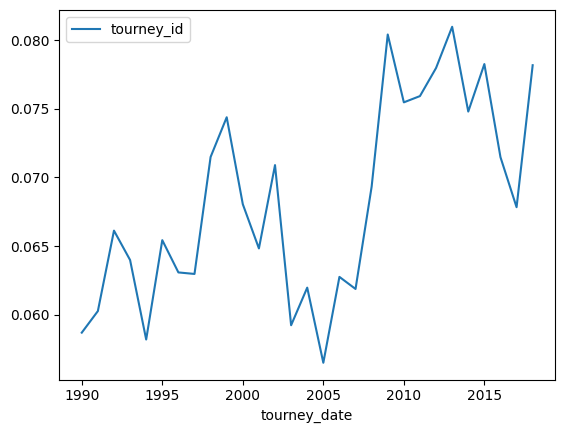

In [ ]:
sns.lineplot(data=chance_to_win_in_5)

Как мы видим, вероятность победы в первом случае будет выше. Теперь проверим это статистически. Возьмём за нулевую гипотизу тот факт, что в среднем игроки должны побеждать в 50 процентов случаев:

In [ ]:
stats.ttest_1samp(chance_to_win_more_than_20['tourney_id'], popmean=0.5)

Ttest_1sampResult(statistic=-80.3509400749578, pvalue=1.1735862363969954e-34)

In [ ]:
stats.ttest_1samp(chance_to_win_in_5['tourney_id'], popmean=0.5)

Ttest_1sampResult(statistic=-316.86353834788497, pvalue=2.5623256563119317e-51)

Хоть и гипотеза не подтверждается в каждом случае, всё-таки шансы выше в первом случае.

2. Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Возьмём за нулевую гепотезу то, что среднее количество сетов равно между двумя выборками (с 1980 до 2001 гг. и 2002-2022 гг.). В качестве альтернативной гипотезы возьмём то, что среднее количество сетов в первой выборке будет больше, чем во второй. Для начала сформируем датасеты:

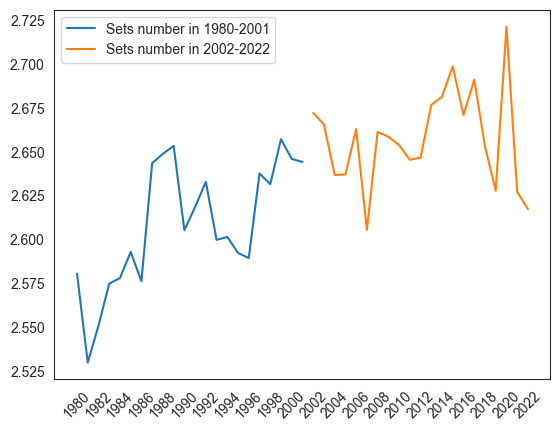

In [ ]:
min_year_2_1 = 1980
max_year_2_1 = 2001

years_2_1 = []
for i in range(min_year_2_1, max_year_2_1 + 1):
    years_2_1.append(i)

sets_2_1 = df.loc[
    (df["tourney_date"].dt.year >= min_year_2_1) &
    (df["tourney_date"].dt.year <= max_year_2_1)
].copy()

min_year_2_2 = 2002
max_year_2_2 = 2022

years_2_2 = []
for i in range(min_year_2_2, max_year_2_2 + 1):
    years_2_2.append(i)

sets_2_2 = df.loc[
    (df["tourney_date"].dt.year >= min_year_2_2) &
    (df["tourney_date"].dt.year <= max_year_2_2)
].copy()

annual_sets_2_1 = sets_2_1.groupby(sets_2_1["tourney_date"].dt.year).mean(numeric_only = True)
annual_sets_2_2 = sets_2_2.groupby(sets_2_2["tourney_date"].dt.year).mean(numeric_only = True)

plt.xticks(np.arange(min_year_2_1, max_year_2_2 + 2, 2), rotation=45)
plt.plot(years_2_1, annual_sets_2_1['sets_num'], label="Sets number in 1980-2001")
plt.plot(years_2_2, annual_sets_2_2['sets_num'], label="Sets number in 2002-2022")
plt.legend()

Визуально видно, что наша гипотеза не подтверждается. Докажет это статистически! Будем использовать Т-тест. Для начала убедимся, что мы имеем достаточную выборку (>30):

In [ ]:
print("set1 size =", sets_2_1["sets_num"].size)
print("set2 size =", sets_2_2["sets_num"].size)

set1 size = 67847
set2 size = 60623


Выборка достаточна. Теперь проверим, нормально ли распредены выборки:

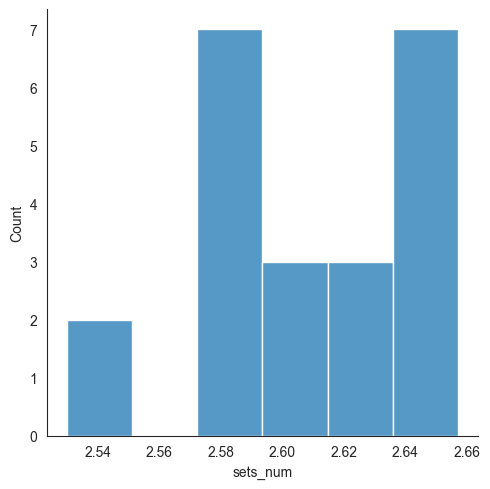

In [ ]:
sns.displot(annual_sets_2_1['sets_num'])

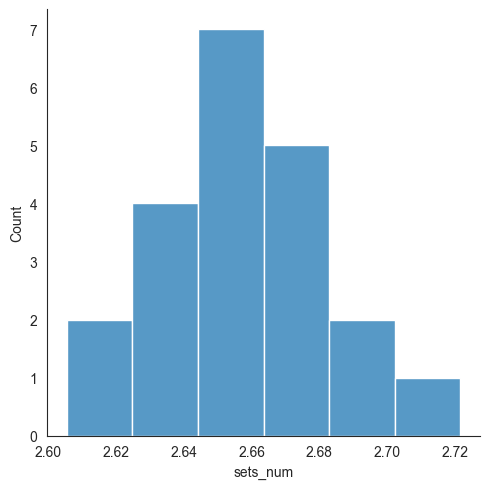

In [ ]:
sns.displot(annual_sets_2_2['sets_num'])

Мы видим, что распределения отличаются. Проверим, нормальные ли они с помощью теста Шапиро:

In [ ]:
stats.shapiro(annual_sets_2_1['sets_num'])

ShapiroResult(statistic=0.9417749047279358, pvalue=0.2153041511774063)

In [ ]:
stats.shapiro(annual_sets_2_2['sets_num'])

ShapiroResult(statistic=0.9916186332702637, pvalue=0.9993129372596741)

По резулятам теста видно, что вторая выборка распределена нормально. Первая выборка тоже распределена скорее нормально. Теперь проведём Т-тест, но с флагом equal_var=False. Этот флаг позволяет указать, что распределения в выборках не одинаковы:

In [ ]:
stats.ttest_ind(
    annual_sets_2_1["sets_num"], annual_sets_2_2["sets_num"], alternative="greater", equal_var=False
)

Ttest_indResult(statistic=-5.0775267616980475, pvalue=0.9999952695580953)

По результатам теста видно, что альтернативная гипотеза не подтвердилась. Можно попробовать в качестве альтернативной гипотезы взять то, что среднее количество сетов в первой выборке будет меньше, чем во второй. Проведём следующий Т-тест:

In [ ]:
stats.ttest_ind(
    annual_sets_2_1["sets_num"], annual_sets_2_2["sets_num"], alternative="less", equal_var=False
)

Ttest_indResult(statistic=-5.0775267616980475, pvalue=4.730441904781452e-06)

И действительно, альтернативная гипотеза подтвердилась. Таким образом можно считать, что в 2002-2022 гг. среднее количество сетов, которое необходимо любому игроку для победы в матче больше чем в периоде с 1980 до 2001 гг.

3. У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Введём дополнительное условие - будем рассматривать только best of 5 сеты:

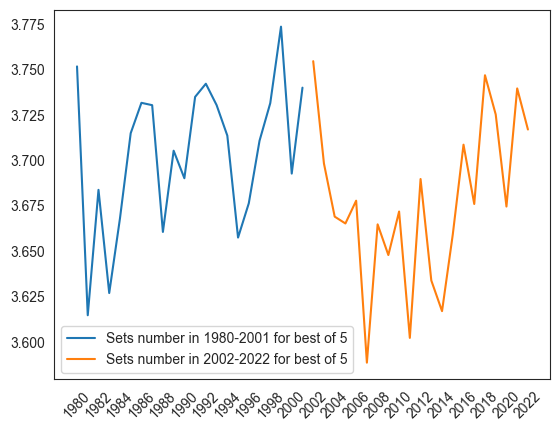

In [ ]:
sets_3_1 = df.loc[
    (df["tourney_date"].dt.year >= min_year_2_1) &
    (df["tourney_date"].dt.year <= max_year_2_1) &
    (df["best_of"] == 5)
].copy()

sets_3_2 = df.loc[
    (df["tourney_date"].dt.year >= min_year_2_2) &
    (df["tourney_date"].dt.year <= max_year_2_2) &
    (df["best_of"] == 5)
].copy()

annual_sets_3_1 = sets_3_1.groupby(sets_3_1["tourney_date"].dt.year).mean(numeric_only = True)
annual_sets_3_2 = sets_3_2.groupby(sets_3_2["tourney_date"].dt.year).mean(numeric_only = True)

plt.xticks(np.arange(min_year_2_1, max_year_2_2 + 2, 2), rotation=45)
plt.plot(years_2_1, annual_sets_3_1['sets_num'], label="Sets number in 1980-2001 for best of 5")
plt.plot(years_2_2, annual_sets_3_2['sets_num'], label="Sets number in 2002-2022 for best of 5")
plt.legend()

Визуально видно, что наша гипотеза подтверждается. Докажет это статистически! Будем использовать Т-тест. Для начала убедимся, что мы имеем достаточную выборку (>30):

In [ ]:
print("set1 size =", sets_3_1["sets_num"].size)
print("set2 size =", sets_3_2["sets_num"].size)

set1 size = 13242
set2 size = 13631


Выборка достаточна. Теперь проверим, нормально ли распредены выборки:

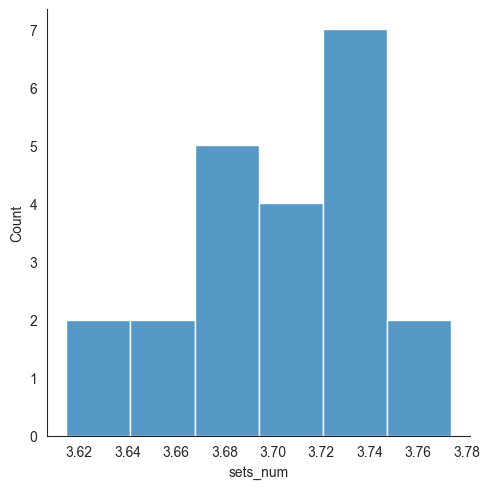

In [ ]:
sns.displot(annual_sets_3_1['sets_num'])

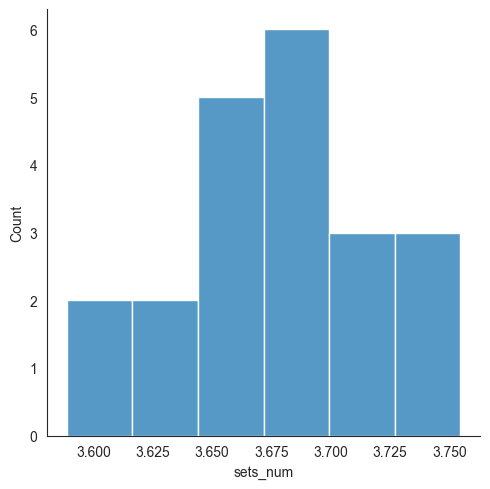

In [ ]:
sns.displot(annual_sets_3_2['sets_num'])

Мы видим, что распределения в общих чертах похожи. Проверим, нормальные ли они с помощью теста Шапиро:

In [ ]:
stats.shapiro(annual_sets_3_1['sets_num'])

ShapiroResult(statistic=0.9588582515716553, pvalue=0.46654996275901794)

In [ ]:
stats.shapiro(annual_sets_3_2['sets_num'])

ShapiroResult(statistic=0.9729715585708618, pvalue=0.7975496053695679)

По резулятам теста видно, что выборки распределены нормально. Теперь проведём Т-тест, но с флагом equal_var=False. Этот флаг позволяет указать, что распределения в выборках не одинаковы:

In [ ]:
stats.ttest_ind(
    annual_sets_3_1["sets_num"], annual_sets_3_2["sets_num"], alternative="greater", equal_var=False
)

Ttest_indResult(statistic=1.9961653374977666, pvalue=0.02637028057933122)

P-value меньше 0,05, а значит альтернативная гипотеза подтвердилась. Таким образом можно считать, что в 2002-2022 гг. среднее количество сетов в играх best of 5, которое необходимо любому игроку для победы в матче меньше чем в периоде с 1980 до 2001 гг.

4. Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

Подготовим дата-сет:

In [ ]:
min_year_4 = 2007
max_year_4 = 2017

years_4 = []
for i in range(min_year_4, max_year_4 + 1):
    years_4.append(i)

sets_4 = df.loc[
    (df["tourney_date"].dt.year >= min_year_4) &
    (df["tourney_date"].dt.year <= max_year_4)
].copy()

Возьмём на рассмотрение трёх игроков примерно одного ранга - Rafael Nadal, Novak Djokovic и Roger Federer:

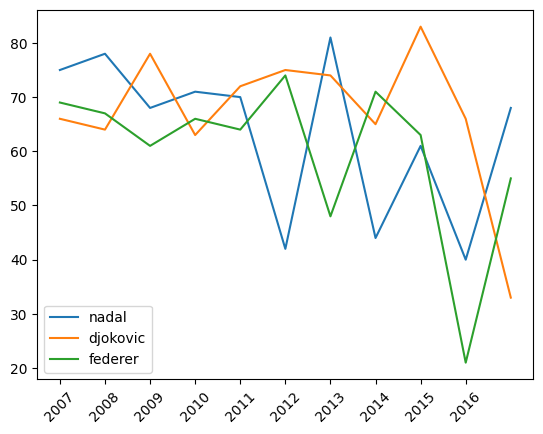

In [ ]:
nadal_wins = sets_4.loc[sets_4["winner_name"] == "Rafael Nadal"].copy()
nadal_loses = sets_4.loc[sets_4["loser_name"] == "Rafael Nadal"].copy()
djokovic_wins = sets_4.loc[sets_4["winner_name"] == "Novak Djokovic"].copy()
djokovic_loses = sets_4.loc[sets_4["loser_name"] == "Novak Djokovic"].copy()
federer_wins = sets_4.loc[sets_4["winner_name"] == "Roger Federer"].copy()
federer_loses = sets_4.loc[sets_4["loser_name"] == "Roger Federer"].copy()

annual_nadal_wins = nadal_wins.groupby(nadal_wins["tourney_date"].dt.year).count()['tourney_id']
annual_djokovic_wins = djokovic_wins.groupby(djokovic_wins["tourney_date"].dt.year).count()['tourney_id']
annual_federer_wins = federer_wins.groupby(federer_wins["tourney_date"].dt.year).count()['tourney_id']

plt.xticks(np.arange(min_year_4, max_year_4, 1), rotation=45)
plt.plot(years_4, annual_nadal_wins, label="nadal")
plt.plot(years_4, annual_djokovic_wins, label="djokovic")
plt.plot(years_4, annual_federer_wins, label="federer")
plt.legend()

Расчитаем для каждого игрока вин-рейт брейк-пойнтов для побед и поражений:

In [ ]:
nadal_wins["bp_winrate"] = nadal_wins['w_bpSaved'] / nadal_wins['w_bpFaced']
nadal_loses["bp_winrate"] = nadal_loses['l_bpSaved'] / nadal_loses['l_bpFaced']
djokovic_wins["bp_winrate"] = djokovic_wins['w_bpSaved'] / djokovic_wins['w_bpFaced']
djokovic_loses["bp_winrate"] = djokovic_loses['l_bpSaved'] / djokovic_loses['l_bpFaced']
federer_wins["bp_winrate"] = federer_wins['w_bpSaved'] / federer_wins['w_bpFaced']
federer_loses["bp_winrate"] = federer_loses['l_bpSaved'] / federer_loses['l_bpFaced']

nadal_bp_winrate = pd.concat(
    [nadal_wins, nadal_loses.rename(columns={"bp_winrate": "bp_winrate_lost"})],
    axis=0
)
djokovic_bp_winrate = pd.concat(
    [djokovic_wins, djokovic_loses.rename(columns={"bp_winrate": "bp_winrate_lost"})],
    axis=0
)
federer_bp_winrate = pd.concat(
    [federer_wins, federer_loses.rename(columns={"bp_winrate": "bp_winrate_lost"})],
    axis=0
)

Объеденим дата-сеты через параметр win/lose и построим box-plot’ы для каждого игрока:

<AxesSubplot: xlabel='win/lose', ylabel='bp_winrate'>

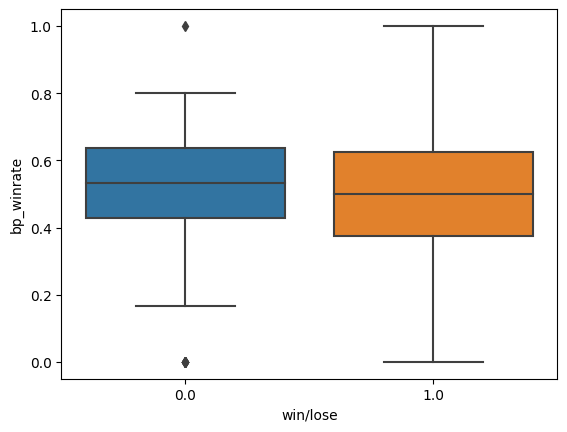

In [ ]:
nadal_bp_loss = pd.concat(
    [
        nadal_loses["tourney_date"].reset_index(drop=True),
        (nadal_loses['l_bpSaved'] / nadal_loses['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.zeros_like(nadal_loses['l_bpSaved']), name='win/lose')
    ], 
    axis=1
)
nadal_bp_loss = nadal_bp_loss.rename(columns={0: 'bp_winrate'})

nadal_bp_win = pd.concat(
    [
        nadal_wins["tourney_date"].reset_index(drop=True),
        (nadal_wins['l_bpSaved'] / nadal_wins['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.ones_like(nadal_wins['w_ace']), name='win/lose')
    ], 
    axis=1
)
nadal_bp_win = nadal_bp_win.rename(columns={0: 'bp_winrate'})

nadal_bp_data = pd.concat([nadal_bp_win, nadal_bp_loss])
nadal_bp_data = nadal_bp_data.reset_index(drop=True)

sns.boxplot(data=nadal_bp_data, x='win/lose', y='bp_winrate')

<AxesSubplot: xlabel='win/lose', ylabel='bp_winrate'>

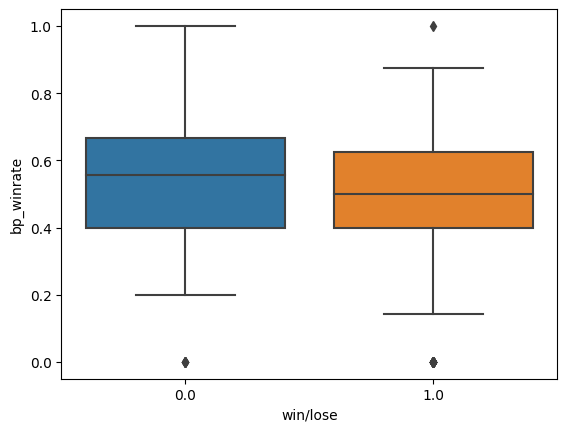

In [ ]:
djokovic_bp_loss = pd.concat(
    [
        djokovic_loses["tourney_date"].reset_index(drop=True),
        (djokovic_loses['l_bpSaved'] / djokovic_loses['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.zeros_like(djokovic_loses['l_bpSaved']), name='win/lose')
    ], 
    axis=1
)
djokovic_bp_loss = djokovic_bp_loss.rename(columns={0: 'bp_winrate'})

djokovic_bp_win = pd.concat(
    [
        djokovic_wins["tourney_date"].reset_index(drop=True),
        (djokovic_wins['l_bpSaved'] / djokovic_wins['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.ones_like(djokovic_wins['w_ace']), name='win/lose')
    ], 
    axis=1
)
djokovic_bp_win = djokovic_bp_win.rename(columns={0: 'bp_winrate'})

djokovic_bp_data = pd.concat([djokovic_bp_win, djokovic_bp_loss])
djokovic_bp_data = djokovic_bp_data.reset_index(drop=True)

sns.boxplot(data=djokovic_bp_data, x='win/lose', y='bp_winrate')

<AxesSubplot: xlabel='win/lose', ylabel='bp_winrate'>

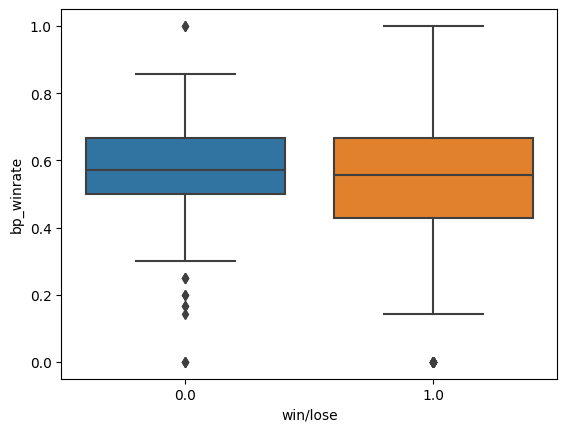

In [ ]:
federer_bp_loss = pd.concat(
    [
        federer_loses["tourney_date"].reset_index(drop=True),
        (federer_loses['l_bpSaved'] / federer_loses['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.zeros_like(federer_loses['l_bpSaved']), name='win/lose')
    ], 
    axis=1
)
federer_bp_loss = federer_bp_loss.rename(columns={0: 'bp_winrate'})

federer_bp_win = pd.concat(
    [
        federer_wins["tourney_date"].reset_index(drop=True),
        (federer_wins['l_bpSaved'] / federer_wins['l_bpFaced']).reset_index(drop=True), 
        pd.Series(np.ones_like(federer_wins['w_ace']), name='win/lose')
    ], 
    axis=1
)
federer_bp_win = federer_bp_win.rename(columns={0: 'bp_winrate'})

federer_bp_data = pd.concat([federer_bp_win, federer_bp_loss])
federer_bp_data = federer_bp_data.reset_index(drop=True)

sns.boxplot(data=federer_bp_data, x='win/lose', y='bp_winrate')

Теперь сделаем разбиение по годам для каждого игрока:

In [ ]:
nadal_bp_data_by_year = nadal_bp_data.groupby(nadal_bp_data["tourney_date"].dt.year, as_index=True).mean(numeric_only=True)
djokovic_bp_data_by_year = djokovic_bp_data.groupby(djokovic_bp_data["tourney_date"].dt.year, as_index=True).mean(numeric_only=True)
federer_bp_data_by_year = federer_bp_data.groupby(federer_bp_data["tourney_date"].dt.year, as_index=True).mean(numeric_only=True)

<AxesSubplot: xlabel='tourney_date', ylabel='win/lose'>

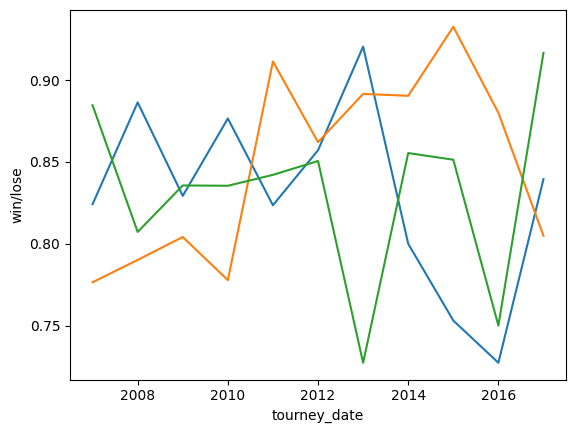

In [ ]:
sns.lineplot(data=nadal_bp_data_by_year["win/lose"])
sns.lineplot(data=djokovic_bp_data_by_year["win/lose"])
sns.lineplot(data=federer_bp_data_by_year["win/lose"])

5. У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.